Данный notebook создан в рамках выполнения магистерской выпускной квалификационной работы Мурзина Михаила Владимировича по интеграции графов знаний в системы управления обучением

In [2]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Загрузка и предобработка данных
df = pd.read_csv('students_interests.csv')  # Замените на путь к вашему CSV-файлу
df.dropna(subset=['Описание интересов студента'], inplace=True)

# Токенизация и векторизация интересов студентов
vectorizer = TfidfVectorizer()  # для русского языка можно не указывать стоп-слова
X = vectorizer.fit_transform(df['Описание интересов студента']).toarray()

# Преобразование классов в числовой формат
classes = df['Класс'].unique()
class_map = {cls: idx for idx, cls in enumerate(classes)}
y = np.array([class_map[cls] for cls in df['Класс']])

# 2. Построение графа на основе косинусного сходства
cosine_sim = cosine_similarity(X, X)
edges = []
threshold = 0.5  # Порог схожести
n = len(df)
for i in range(n):
    for j in range(i + 1, n):
        if cosine_sim[i, j] > threshold:
            edges.append([i, j])
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

# 3. Создание объекта Data для PyTorch Geometric
x = torch.tensor(X, dtype=torch.float)
edge_index = edges  # Уже tensor
y = torch.tensor(y, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# Разделение данных на обучающую и тестовую выборки через индексы и создание масок
num_nodes = len(y)
indices = np.arange(num_nodes)
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

# 4. Определение модели GAT
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Если concat=True (по умолчанию), выходной размер = hidden_channels * heads
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 5. Инициализация модели, оптимизатора, функции потерь и lr_scheduler
model = GAT(in_channels=X.shape[1], hidden_channels=8, out_channels=len(classes), heads=8, dropout=0.5).to(device)
data = data.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# 6. Функции для обучения и оценки модели с градиентным клиппингом
def train_epoch(model, data, optimizer, criterion, clip_value=1.0):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
    optimizer.step()
    return loss.item()

def evaluate(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item()
    correct_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    train_acc = correct_train / data.train_mask.sum().item()
    test_acc = correct_test / data.test_mask.sum().item()
    return train_acc, test_acc

# 7. Обучение модели и сбор метрик
epochs = 80
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    loss = train_epoch(model, data, optimizer, criterion)
    train_acc, test_acc = evaluate(model, data)
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    scheduler.step(loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch: 010, Loss: 1.8714, Train Acc: 0.9054, Test Acc: 0.7105
Epoch: 020, Loss: 1.6222, Train Acc: 0.9932, Test Acc: 0.7632
Epoch: 030, Loss: 1.3202, Train Acc: 1.0000, Test Acc: 0.8684
Epoch: 040, Loss: 1.0530, Train Acc: 1.0000, Test Acc: 0.8947
Epoch: 050, Loss: 0.9800, Train Acc: 1.0000, Test Acc: 0.9474
Epoch: 060, Loss: 0.9999, Train Acc: 1.0000, Test Acc: 0.9474
Epoch: 070, Loss: 1.0867, Train Acc: 1.0000, Test Acc: 0.9474
Epoch: 080, Loss: 0.8842, Train Acc: 1.0000, Test Acc: 0.9474


Визуализация результатов обучения

<ipython-input-8-b14a6a43b08a>:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


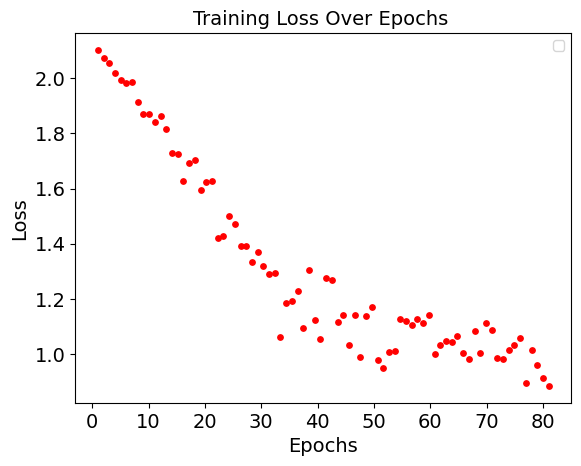

In [8]:
x_epochs = np.linspace(1, epochs+1, epochs)
plt.scatter(x_epochs , train_losses,  color='red', s=15)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Over Epochs ', fontsize=14)
plt.legend()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

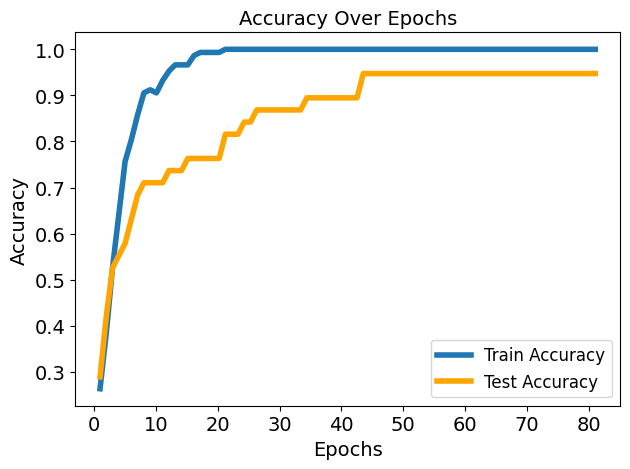

In [9]:
plt.plot(x_epochs, train_accuracies, label='Train Accuracy',linewidth=4 )
plt.plot(x_epochs, test_accuracies, label='Test Accuracy',  color='orange', linewidth = 4)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Accuracy Over Epochs', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.tight_layout()
plt.show()

Выгрузка весов нейронной сети

In [10]:
import torch

torch.save(model.state_dict(), 'model_final_weights.pth')

Визуализация графа исходных данных

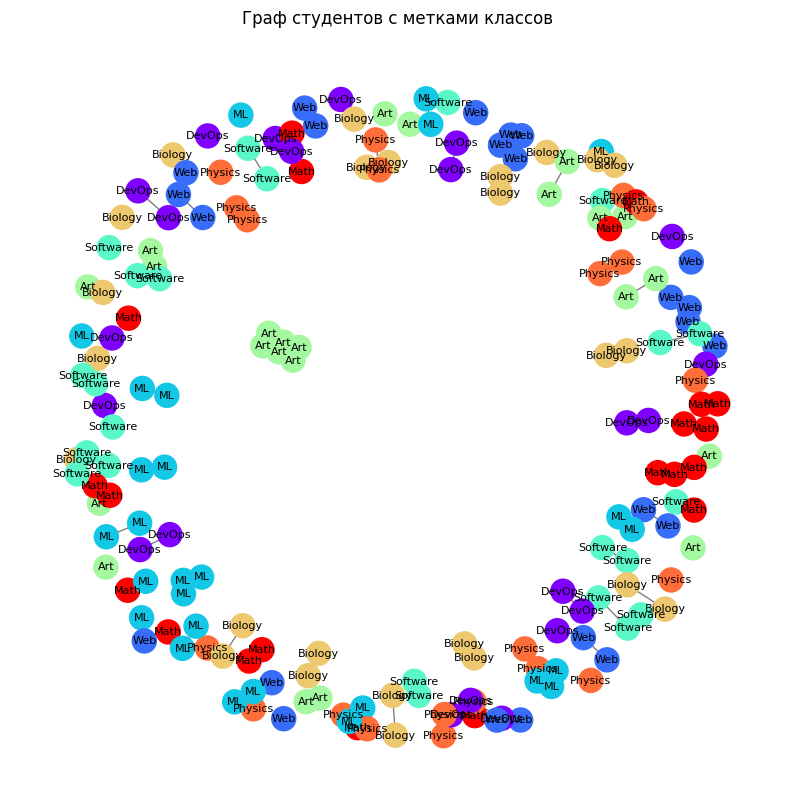

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1. Загрузка и предобработка данных
df = pd.read_csv('students_interests.csv')  # Замените на путь к вашему CSV-файлу
df.dropna(subset=['Описание интересов студента'], inplace=True)

# 2. Векторизация текстовых описаний
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Описание интересов студента']).toarray()

# 3. Построение графа на основе косинусного сходства
threshold = 0.5  # Порог схожести для добавления ребра
n = len(df)
edges = []
for i in range(n):
    for j in range(i + 1, n):
        sim = cosine_similarity([X[i]], [X[j]])[0][0]
        if sim > threshold:
            edges.append((i, j))

# Создаём граф NetworkX
G = nx.Graph()

# Добавляем узлы и присваиваем каждому атрибут 'label' с классом
for idx, row in df.iterrows():
    G.add_node(idx, label=row['Класс'])

# Добавляем ребра
G.add_edges_from(edges)

# 4. Назначение цветов узлам по меткам классов
unique_classes = df['Класс'].unique()
# Используем колормэп, чтобы распределить цвета между классами
colors = cm.rainbow(np.linspace(0, 1, len(unique_classes)))
class_color_map = {cls: colors[i] for i, cls in enumerate(unique_classes)}

# Составляем список цветов для узлов по их метке
node_colors = [class_color_map[G.nodes[node]['label']] for node in G.nodes()]

# 5. Визуализация графа
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.15, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Для подписей можно отобразить класс или другой атрибут
labels = {node: G.nodes[node]['label'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
plt.title("Граф студентов с метками классов")
plt.axis('off')
plt.show()
